In [24]:
import pandas as pd
import os
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rasterio
from rasterio.windows import from_bounds
import shutil

mpl.style.use("ggplot")

### Load climate data from [CHELSA](https://chelsa-climate.org/bioclim/)

In [25]:
with open("./envidatS3paths.txt", "r") as file:
    urls = file.readlines()

In [29]:
for url in urls:
    url = url.strip()
    filename = os.path.join("./climate_data/", os.path.basename(url))
    print(f"Downloading {url} to {filename}")
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, "wb") as f:
            f.write(response.content)
        print(f"Downloaded {filename}")
    else:
        print(f"Failed to download {url}. Status: {response.status_code}")
# 40 minutes, 17 GB

Downloaded ./climate_data/CHELSA_ai_1981-2010_V.2.1.tif
Downloaded ./climate_data/CHELSA_bio10_1981-2010_V.2.1.tif
Downloaded ./climate_data/CHELSA_bio11_1981-2010_V.2.1.tif
Downloaded ./climate_data/CHELSA_bio12_1981-2010_V.2.1.tif
Downloaded ./climate_data/CHELSA_bio13_1981-2010_V.2.1.tif
Downloaded ./climate_data/CHELSA_bio14_1981-2010_V.2.1.tif
Downloaded ./climate_data/CHELSA_bio15_1981-2010_V.2.1.tif
Downloaded ./climate_data/CHELSA_bio16_1981-2010_V.2.1.tif
Downloaded ./climate_data/CHELSA_bio17_1981-2010_V.2.1.tif
Downloaded ./climate_data/CHELSA_bio18_1981-2010_V.2.1.tif
Downloaded ./climate_data/CHELSA_bio19_1981-2010_V.2.1.tif
Downloaded ./climate_data/CHELSA_bio1_1981-2010_V.2.1.tif
Downloaded ./climate_data/CHELSA_bio2_1981-2010_V.2.1.tif
Downloaded ./climate_data/CHELSA_bio3_1981-2010_V.2.1.tif
Downloaded ./climate_data/CHELSA_bio4_1981-2010_V.2.1.tif
Downloaded ./climate_data/CHELSA_bio5_1981-2010_V.2.1.tif
Downloaded ./climate_data/CHELSA_bio6_1981-2010_V.2.1.tif
Downlo

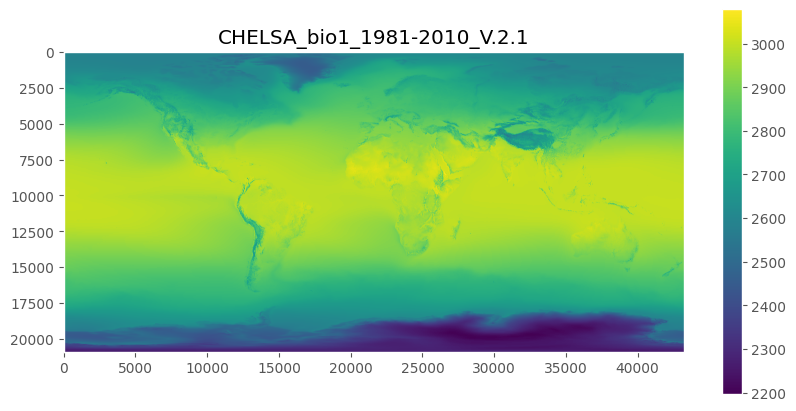

In [31]:
# plot 1 to view extent
with rasterio.open("./climate_data/CHELSA_bio1_1981-2010_V.2.1.tif") as dataset:
    band1 = dataset.read(1)
    fig, ax = plt.subplots(figsize=(10, 10))
    img = ax.imshow(band1, cmap="viridis")
    cbar = plt.colorbar(img, ax=ax, shrink=0.5)
    ax.set_title("CHELSA_bio1_1981-2010_V.2.1")
    ax.grid(False)
    plt.show()

In [32]:
# check that all geotiffs have 1 band
os.environ["GTIFF_SRS_SOURCE"] = "EPSG"


def check_bands_in_geotiffs(directory):
    results = []
    for filename in os.listdir(directory):
        if filename.endswith(".tif"):
            file_path = os.path.join(directory, filename)
            with rasterio.open(file_path) as dataset:
                band_count = dataset.count
                if band_count > 1:
                    results.append((filename, band_count))
                    print(f"{filename} = {band_count} band(s)")
    return results


results = check_bands_in_geotiffs("./climate_data")

### Open geotiffs to smaller extent

In [33]:
with rasterio.open("./climate_data/CHELSA_bio1_1981-2010_V.2.1.tif") as dataset:
    print("Dataset bounds:", dataset.bounds)
    print("Dataset CRS:", dataset.crs)

Dataset bounds: BoundingBox(left=-180.00013888885002, bottom=-90.00013888884999, right=179.99985967115003, top=83.99986041515001)
Dataset CRS: EPSG:4326


In [34]:
# reduce the amount of data we need to process
california_extent = [-125, 32, -113, 43]

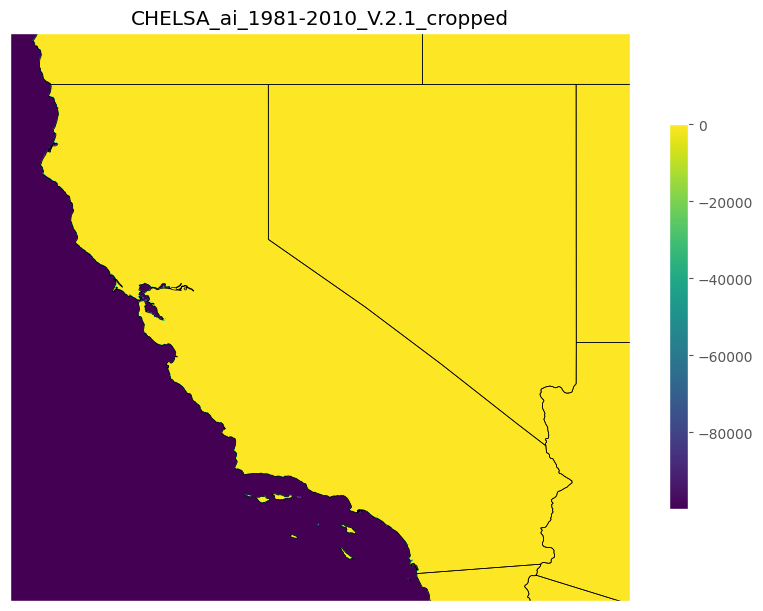

In [35]:
# open geotiff and read metadata
with rasterio.open("./climate_data/CHELSA_ai_1981-2010_V.2.1.tif") as dataset:

    # create window for California extent
    transform = dataset.transform
    window = from_bounds(*california_extent, transform=transform)

    # read the window only
    band1 = dataset.read(1, window=window)
    img_extent = (
        california_extent[0],
        california_extent[1],
        california_extent[2],
        california_extent[3],
    )

    # plot
    fig, ax = plt.subplots(
        figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}
    )
    img = ax.imshow(
        band1,
        cmap="viridis",
        extent=[img_extent[0], img_extent[2], img_extent[1], img_extent[3]],
        origin="upper",
    )
    ax.add_feature(cfeature.STATES.with_scale("10m"))
    cbar = plt.colorbar(img, ax=ax, shrink=0.5)
    ax.set_title("CHELSA_ai_1981-2010_V.2.1_cropped")
    ax.grid(False)
    plt.show()

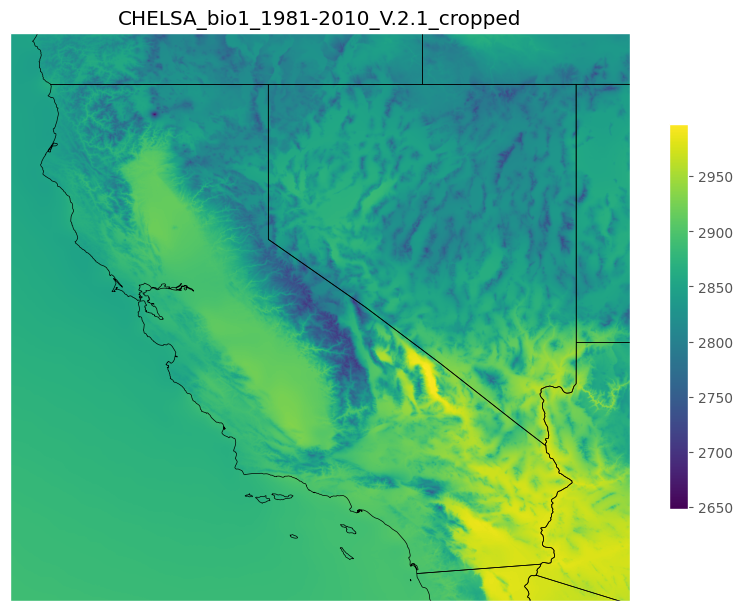

In [36]:
with rasterio.open("./climate_data/CHELSA_bio1_1981-2010_V.2.1.tif") as dataset:

    # create window for California extent
    transform = dataset.transform
    window = from_bounds(*california_extent, transform=transform)

    # read the window only
    band1 = dataset.read(1, window=window)
    img_extent = (
        california_extent[0],
        california_extent[1],
        california_extent[2],
        california_extent[3],
    )

    # plot
    fig, ax = plt.subplots(
        figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}
    )
    img = ax.imshow(
        band1,
        cmap="viridis",
        extent=[img_extent[0], img_extent[2], img_extent[1], img_extent[3]],
        origin="upper",
    )
    ax.add_feature(cfeature.STATES.with_scale("10m"))
    cbar = plt.colorbar(img, ax=ax, shrink=0.5)
    ax.set_title("CHELSA_bio1_1981-2010_V.2.1_cropped")
    ax.grid(False)
    plt.show()

### Load kikuyugrass observation locations

In [37]:
data = pd.read_csv("./inaturalist_observations_cleaned.csv")

In [38]:
# download df of lat long and uuid
data[["lat", "long"]] = data["location"].str.split(",", expand=True)
data["lat"] = data["lat"].astype(float)
data["long"] = data["long"].astype(float)

In [39]:
location_data = data[["lat", "long", "uuid"]]
location_data = pd.DataFrame(location_data)
location_data.head()

,lat,long,uuid
0,34.041287,-118.532091,cf6f9a84-0996-4ded-b2e0-a7bd12d67217
1,32.658961,-117.060481,39f544ee-5509-49ea-a296-19c825217ee1
2,35.322144,-120.823204,28751c0a-3cd3-4f64-9058-75e564f328f8
3,37.831630,-122.534875,03159809-00bc-4852-bbd6-2aab8038a6ba
4,32.737291,-117.126908,192ed8dc-5066-42cb-b58f-8cf69f070b2a


### Extract climate data at each observation

In [10]:
directory = "./climate_data"

california_extent = [-125, 32, -113, 43]

for filename in os.listdir(directory):
    if filename.endswith(".tif"):
        # extract variable name from filename
        variable_name = filename.split("_")[1]
        file_path = os.path.join(directory, filename)

        # open raster to subset of California extent
        with rasterio.open(file_path) as dataset:
            # prep lat long points
            coords = [
                (x, y) for x, y in zip(location_data["long"], location_data["lat"])
            ]

            # sample raster at these points
            sampled_values = list(dataset.sample(coords))
            sampled_values = [value[0] for value in sampled_values]

            # add extracted values to dataframe
            location_data[variable_name] = sampled_values

In [11]:
location_data.head()

,lat,long,uuid,ai,bio10,bio11,bio12,bio13,bio14,bio15,...,ngd10,ngd5,npp,pet,rsds,scd,sfcWind,swb,swe,vpd
0,34.041287,-118.532091,cf6f9a84-0996-4ded-b2e0-a7bd12d67217,0.331897,2950,2862,3857,966,6,998,...,365,365,6562,12501,18098,0,364,-980,65535,4835
1,32.658961,-117.060481,39f544ee-5509-49ea-a296-19c825217ee1,0.286715,2938,2869,2806,571,14,887,...,365,365,4931,10485,17475,0,155,-858,65535,2625
2,35.322144,-120.823204,28751c0a-3cd3-4f64-9058-75e564f328f8,0.550209,2912,2851,5192,1067,7,946,...,365,365,8482,12271,20092,0,599,-756,65535,2197
3,37.831630,-122.534875,03159809-00bc-4852-bbd6-2aab8038a6ba,-99999.000000,2887,2837,7961,1621,9,928,...,348,365,11976,9117,19836,0,1714,-645,65535,1266
4,32.737291,-117.126908,192ed8dc-5066-42cb-b58f-8cf69f070b2a,0.278504,2939,2866,2782,568,11,893,...,365,365,4893,10851,17513,0,186,-891,65535,2424


In [19]:
# points with ai -99999 are in the ocean
print(location_data[location_data["ai"] <= -99999].shape[0])

# throw them out now, although they may be ok
location_data = location_data[location_data["ai"] > -99999]

16


### Save csv of climate data

In [20]:
location_data.to_csv("./location_coords_climate_data.csv")

### Delete geotiffs because they are very large files

In [22]:
# if os.path.exists(directory):
#    shutil.rmtree(directory)